# Volatility Forecasting

_This setup code is required to run in an IPython notebook_

In [1]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import seaborn
seaborn.mpl.rcParams['figure.figsize'] = (10.0, 6.0)
seaborn.mpl.rcParams['savefig.dpi'] = 90

## Data
These examples make use of S&P 500 data from Yahoo! using the pandas-datareader package to manage data download.

In [2]:
import datetime as dt
import sys

import numpy as np
import pandas as pd
import pandas_datareader.data as web

from arch import arch_model

start = dt.datetime(2000,1,1)
end = dt.datetime(2017,1,1)
sp500 = web.get_data_yahoo('^GSPC', start=start, end=end)
returns = 100 * sp500['Adj Close'].pct_change().dropna()

## Basic Forecasting
Forecasts can be generated for standard GARCH(p,q) processes using any of the three forecast generation methods:

* Analytical
* Simulation-based
* Bootstrap-based

Be default forecasts will only be produced for the final observation in the sample so that they are out-of-sample.

Forecasts start with specifying the model and estimating parameters.

In [3]:
am = arch_model(returns, vol='Garch', p=1, o=0, q=1, dist='Normal')
res = am.fit(update_freq=5)

Iteration:      5,   Func. Count:     39,   Neg. LLF: 6031.2332529686
Iteration:     10,   Func. Count:     71,   Neg. LLF: 6028.8808621264125
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6028.88083147
            Iterations: 11
            Function evaluations: 78
            Gradient evaluations: 11


In [4]:
forecasts = res.forecast()

Forecasts are contained in an `ARCHModelForecast` object which has 4 attributes:

* `mean` - The forecast means
* `residual_variance` - The forecast residual variances, that is $E_t[\epsilon_{t+h}^2]$
* `variance` - The forecast variance of the process, $E_t[r_{t+h}^2]$.  The variance will differ from the residual variance whenever the model has mean dynamics, e.g., in an AR process.
* `simulations` - An object that contains detailed information about the simulations used to generate forecasts.  Only used if the forecast `method` is set to `'simulation'` or `'bootstrap'`.  If using `'analytical'` (the default), this is `None`.

The three main outputs are all returned in `DataFrame`s with columns of the form `h.#` where `#` is the number of steps ahead.  That is, `h.1` corresponds to one-step ahead forecasts while `h.10` corresponds to 10-steps ahead.

The default forecast only produces 1-step ahear forecasts.

In [5]:
print(forecasts.mean.iloc[-3:])
print(forecasts.residual_variance.iloc[-3:])
print(forecasts.variance.iloc[-3:])

                 h.1
Date                
2016-12-16       NaN
2016-12-19       NaN
2016-12-20  0.052183
                 h.1
Date                
2016-12-16       NaN
2016-12-19       NaN
2016-12-20  0.383782
                 h.1
Date                
2016-12-16       NaN
2016-12-19       NaN
2016-12-20  0.383782


Longer horizon forecasts can be computed by passing the parameter `horizon`.

In [6]:
forecasts = res.forecast(horizon=5)
print(forecasts.residual_variance.iloc[-3:])

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2016-12-16       NaN       NaN       NaN       NaN       NaN
2016-12-19       NaN       NaN       NaN       NaN       NaN
2016-12-20  0.383782  0.398705  0.413379  0.427808  0.441996


Values that are not computed are ``nan``-filled.

## Alternative Forecast Generation Schemes

### Fixed Window Forecasting

Fixed-windows forecasting uses data up to a specified date to generate all forecasts after that date. This cna be implemented by passing the entire data in when initializing the model and then using ``last_obs`` when calling ``fit``.  ``forecast()`` will, by default, produce forecasts after this final date.

**Note** ``last_obs`` follow Python sequence rules so that the actual date in ``last_obs`` is not in the sample.

In [7]:
res = am.fit(last_obs = '2011-1-1', update_freq=5)
forecasts = res.forecast(horizon=5)
print(forecasts.variance.dropna().head())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 4157.973788419826
Iteration:     10,   Func. Count:     72,   Neg. LLF: 4155.670884337866
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4155.66693192
            Iterations: 13
            Function evaluations: 90
            Gradient evaluations: 13
                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2010-12-31  0.361732  0.371332  0.380859  0.390314  0.399697
2011-01-03  0.437698  0.446723  0.455681  0.464570  0.473393
2011-01-04  0.413819  0.423025  0.432162  0.441229  0.450228
2011-01-05  0.406429  0.415691  0.424883  0.434005  0.443059
2011-01-06  0.388142  0.397542  0.406871  0.416130  0.425318


### Rolling Window Forecasting

Rolling window forecasts use a fixed sample length and then produce one-step from the final observation.  These can be implemented using ``first_obs`` and ``last_obs``.

In [8]:
index = returns.index
start_loc = 0
end_loc = np.where(index >= '2010-1-1')[0].min()
forecasts = {}
for i in range(20):
    sys.stdout.write('.')
    sys.stdout.flush()
    res = am.fit(first_obs=i, last_obs=i+end_loc, disp='off')
    temp = res.forecast(horizon=3).variance
    fcast = temp.iloc[i+end_loc-1]
    forecasts[fcast.name] = fcast
print()
print(pd.DataFrame(forecasts).T)

....................
                 h.1       h.2       h.3
2009-12-31  0.592770  0.599537  0.606258
2010-01-04  0.741695  0.747594  0.753455
2010-01-05  0.697177  0.703327  0.709438
2010-01-06  0.650562  0.656987  0.663370
2010-01-07  0.618261  0.624963  0.631622
2010-01-08  0.582740  0.589653  0.596520
2010-01-11  0.546604  0.553743  0.560836
2010-01-12  0.584582  0.591458  0.598288
2010-01-13  0.594898  0.601701  0.608459
2010-01-14  0.559686  0.566699  0.573665
2010-01-15  0.619233  0.625857  0.632437
2010-01-19  0.689729  0.695906  0.702042
2010-01-20  0.734718  0.740607  0.746457
2010-01-21  0.968062  0.972529  0.976966
2010-01-22  1.291619  1.294309  1.296981
2010-01-25  1.207096  1.210234  1.213352
2010-01-26  1.132550  1.136086  1.139598
2010-01-27  1.064376  1.068281  1.072160
2010-01-28  1.102316  1.106104  1.109867
2010-01-29  1.103033  1.106945  1.110831


### Recursive Forecast Generation

Recursive is similar to rolling except that the initial observation doesn't change.  This can be easily implemented by dropping the ``first_obs`` input.

In [9]:
import pandas as pd
import numpy as np
index = returns.index
start_loc = 0
end_loc = np.where(index >= '2010-1-1')[0].min()
forecasts = {}
for i in range(20):
    sys.stdout.write('.')
    sys.stdout.flush()
    res = am.fit(last_obs=i+end_loc, disp='off')
    temp = res.forecast(horizon=3).variance
    fcast = temp.iloc[i+end_loc-1]
    forecasts[fcast.name] = fcast
print()
print(pd.DataFrame(forecasts).T)

....................
                 h.1       h.2       h.3
2009-12-31  0.592770  0.599537  0.606258
2010-01-04  0.740400  0.746181  0.751923
2010-01-05  0.696335  0.702391  0.708405
2010-01-06  0.650194  0.656541  0.662845
2010-01-07  0.617491  0.624048  0.630560
2010-01-08  0.582186  0.588973  0.595713
2010-01-11  0.546313  0.553336  0.560311
2010-01-12  0.584236  0.591003  0.597725
2010-01-13  0.594504  0.601203  0.607858
2010-01-14  0.559554  0.566476  0.573352
2010-01-15  0.618935  0.625469  0.631960
2010-01-19  0.689213  0.695305  0.701357
2010-01-20  0.734042  0.739855  0.745629
2010-01-21  0.965800  0.970214  0.974599
2010-01-22  1.285115  1.287657  1.290182
2010-01-25  1.202055  1.205083  1.208091
2010-01-26  1.128661  1.132120  1.135556
2010-01-27  1.061641  1.065497  1.069326
2010-01-28  1.097353  1.100992  1.104607
2010-01-29  1.096228  1.099871  1.103490


## TARCH

### Analytical Forecasts

All ARCH-type models have one-step analytical forecasts.  Longer horizons only have closed forms for specific models.  TARCH models do not have closed-form (analytical) forecasts for horizons larger than 1, and so simulation or bootstrapping is required.  Attempting to produce forecasts for horizons larger than 1 using `method='analytical'` results in a `ValueError`. 

In [10]:
# TARCH specification
am = arch_model(returns, vol='GARCH', power=2.0, p=1, o=1, q=1)
res = am.fit(update_freq=5)
forecasts = res.forecast()
print(forecasts.variance.iloc[-1])

Iteration:      5,   Func. Count:     44,   Neg. LLF: 5932.033656743306
Iteration:     10,   Func. Count:     81,   Neg. LLF: 5928.216764723273
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5928.21663785
            Iterations: 13
            Function evaluations: 102
            Gradient evaluations: 13
h.1    0.311969
Name: 2016-12-20 00:00:00, dtype: float64


### Simulation Forecasts

When using simulation- or bootstrap-based forecasts, an additional attribute of an `ARCHModelForecast` object is meaningful -- `simulation`.

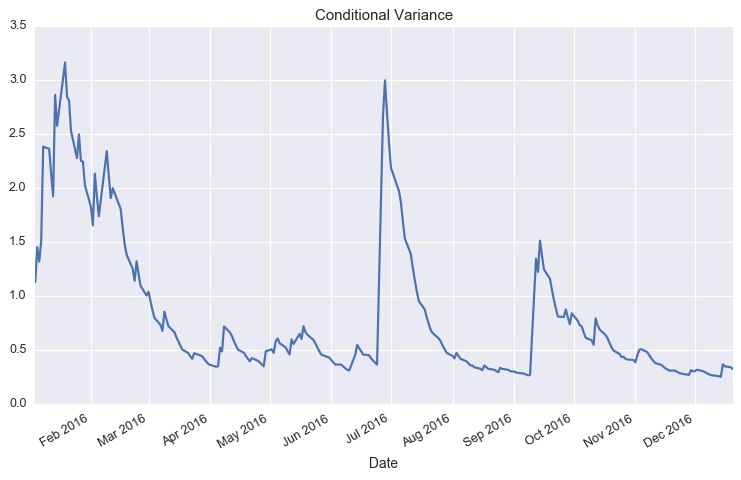

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
(res.conditional_volatility['2016'] ** 2.0).plot(ax=ax, title='Conditional Variance')

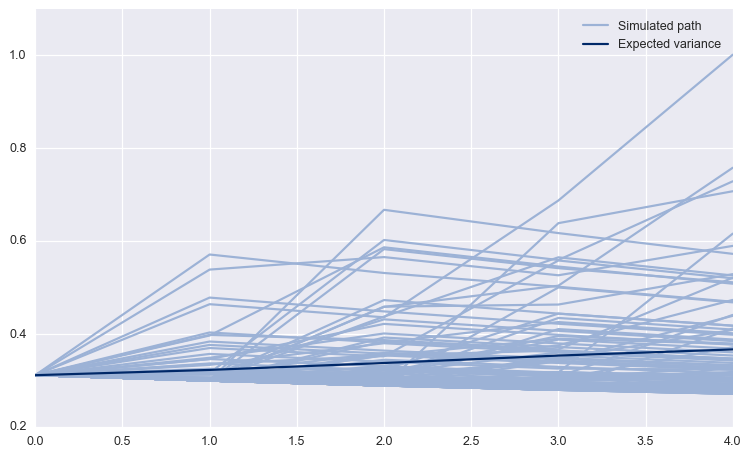

In [12]:
forecasts = res.forecast(horizon=5, method='simulation')
sims = forecasts.simulations

lines = plt.plot(sims.residual_variances[-1,::10].T, color='#9cb2d6')
lines[0].set_label('Simulated path')
plt.hold('on')
line = plt.plot(forecasts.variance.iloc[-1].values, color='#002868')
line[0].set_label('Expected variance')
legend = plt.legend()

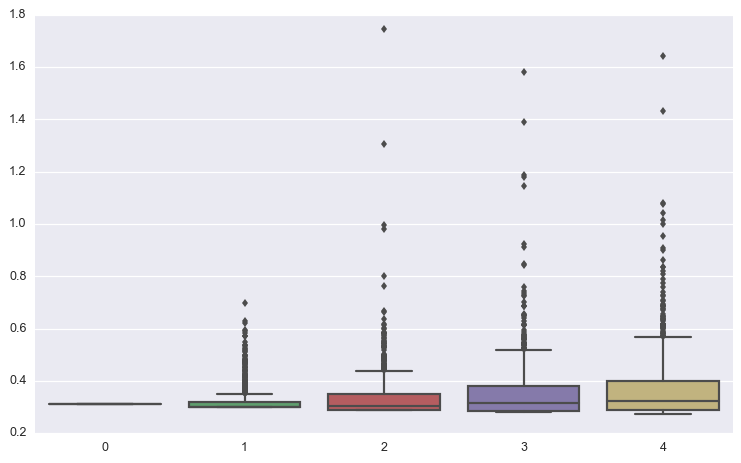

In [13]:
import seaborn as sns
sns.boxplot(data=sims.variances[-1])

### Bootstrap Forecasts

Bootstrap-based forecasts are nearly identical to simulation-based forecasts except that the values used to simulate the process are computed from historical data rather than using the assumed distribution of the residuals. Forecasts produced using this method also return an `ARCHModelForecastSimulation` containing information about the simulated paths.

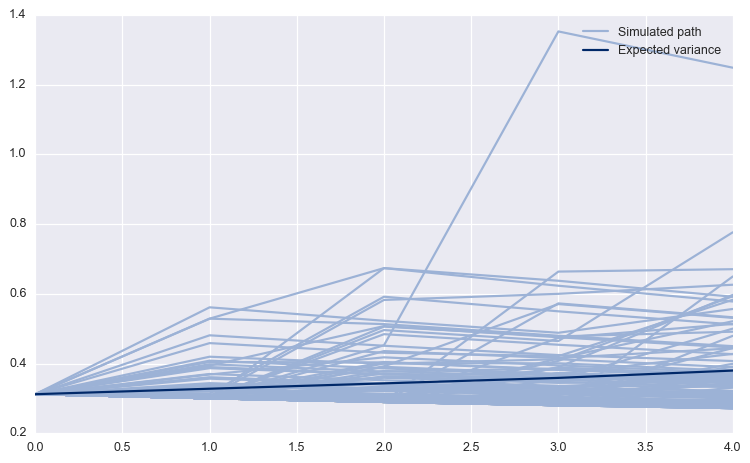

In [14]:
forecasts = res.forecast(horizon=5, method='bootstrap')
sims = forecasts.simulations

lines = plt.plot(sims.residual_variances[-1,::10].T, color='#9cb2d6')
lines[0].set_label('Simulated path')
plt.hold('on')
line = plt.plot(forecasts.variance.iloc[-1].values, color='#002868')
line[0].set_label('Expected variance')
legend = plt.legend()